In [1]:
import yfinance as yf

In [2]:
sp500 = yf.Ticker("LEG")

In [3]:
sp500 = sp500.history(period="max")

In [4]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-03-17 00:00:00-05:00,0.000000,0.162655,0.160961,0.160961,156000,0.0,0.0
1980-03-18 00:00:00-05:00,0.000000,0.160961,0.157572,0.157572,43200,0.0,0.0
1980-03-19 00:00:00-05:00,0.000000,0.157572,0.155878,0.155878,72000,0.0,0.0
1980-03-20 00:00:00-05:00,0.000000,0.154184,0.152490,0.154184,16800,0.0,0.0
1980-03-21 00:00:00-05:00,0.000000,0.154184,0.154184,0.154184,12000,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-02 00:00:00-04:00,25.270000,25.450001,24.889999,25.090000,1120800,0.0,0.0
2023-10-03 00:00:00-04:00,24.910000,25.030001,24.410000,24.549999,1122500,0.0,0.0
2023-10-04 00:00:00-04:00,24.600000,24.730000,24.260000,24.469999,697600,0.0,0.0


In [5]:
sp500.index

DatetimeIndex(['1980-03-17 00:00:00-05:00', '1980-03-18 00:00:00-05:00',
               '1980-03-19 00:00:00-05:00', '1980-03-20 00:00:00-05:00',
               '1980-03-21 00:00:00-05:00', '1980-03-24 00:00:00-05:00',
               '1980-03-25 00:00:00-05:00', '1980-03-26 00:00:00-05:00',
               '1980-03-27 00:00:00-05:00', '1980-03-28 00:00:00-05:00',
               ...
               '2023-09-25 00:00:00-04:00', '2023-09-26 00:00:00-04:00',
               '2023-09-27 00:00:00-04:00', '2023-09-28 00:00:00-04:00',
               '2023-09-29 00:00:00-04:00', '2023-10-02 00:00:00-04:00',
               '2023-10-03 00:00:00-04:00', '2023-10-04 00:00:00-04:00',
               '2023-10-05 00:00:00-04:00', '2023-10-06 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=10983, freq=None)

<AxesSubplot:xlabel='Date'>

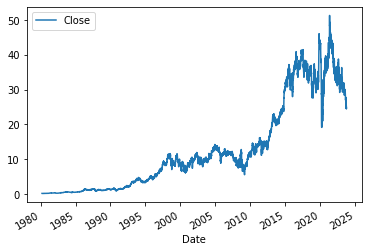

In [6]:
sp500.plot.line(y="Close", use_index=True)

In [7]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [8]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [9]:
sp500["Target"] =  (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [10]:
sp500 = (sp500.loc["1990-01-01":]).copy()

In [11]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [12]:
from sklearn.metrics import precision_score
import pandas as pd
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"],preds)

0.35106382978723405

<AxesSubplot:xlabel='Date'>

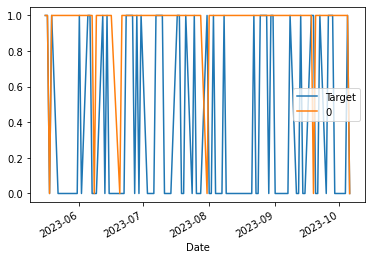

In [13]:
combine = pd.concat([test["Target"],preds], axis=1)
combine.plot()

In [20]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [21]:
def backtest(data, model, predictors, start=2500,step=250):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return  pd.concat(all_predictions)

In [22]:
predictions = backtest(sp500, model, predictors)

In [23]:
predictions["Predictions"].value_counts()

Predictions
0    3334
1    2673
Name: count, dtype: int64

In [25]:
precision_score(predictions["Target"], predictions["Predictions"])

0.4998129442573887

In [26]:
predictions["Target"].value_counts()/predictions.shape[0]

Target
1    0.506909
0    0.493091
Name: count, dtype: float64

In [33]:
horizons = [2,5,60, 250, 1000]
new_predictors = []
for horizon in horizons:
    rolling_average = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column]=  sp500["Close"]/ rolling_average["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    new_predictors += [ratio_column, trend_column]

In [34]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [35]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,4.027941,4.039823,3.968532,4.027941,228800,4.146760,1,1.000000,0.0,1.004742,2.0,0.963433,25.0,1.096202,120.0,1.858003,457.0
1993-12-15 00:00:00-05:00,4.063587,4.146760,4.039823,4.146760,256000,4.206172,1,1.014535,1.0,1.024061,3.0,0.991615,26.0,1.127118,120.0,1.910294,458.0
1993-12-16 00:00:00-05:00,4.134880,4.206172,4.099235,4.206172,180400,4.218052,1,1.007113,2.0,1.027278,3.0,1.005342,27.0,1.141713,121.0,1.935064,459.0
1993-12-17 00:00:00-05:00,4.194288,4.229934,4.158643,4.218052,560400,4.218052,0,1.001410,2.0,1.022466,3.0,1.007558,28.0,1.143398,121.0,1.937905,460.0
1993-12-20 00:00:00-05:00,4.206170,4.301225,4.206170,4.218052,177600,4.146760,0,1.000000,1.0,1.013128,3.0,1.007553,27.0,1.141963,120.0,1.935307,459.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02 00:00:00-04:00,25.270000,25.450001,24.889999,25.090000,1120800,24.549999,0,0.993663,1.0,1.003119,3.0,0.909621,22.0,0.821805,113.0,0.706127,499.0
2023-10-03 00:00:00-04:00,24.910000,25.030001,24.410000,24.549999,1122500,24.469999,0,0.989122,0.0,0.981764,3.0,0.892472,21.0,0.805062,112.0,0.691115,498.0
2023-10-04 00:00:00-04:00,24.600000,24.730000,24.260000,24.469999,697600,24.430000,0,0.998368,0.0,0.979897,2.0,0.892397,20.0,0.803346,112.0,0.689056,497.0


In [37]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [46]:
def predict(train, test, predictors, models):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"],preds], axis=1)
    return combined

In [47]:
new_predictors

['Close_Ratio_2',
 'Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Close_Ratio_60',
 'Trend_60',
 'Close_Ratio_250',
 'Trend_250',
 'Close_Ratio_1000',
 'Trend_1000']

In [48]:
predictions = backtest(sp500, model, new_predictors)

In [49]:
predictions["Predictions"].value_counts()

Predictions
0.0    4497
1.0     510
Name: count, dtype: int64

In [51]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5372549019607843

In [52]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.512483
0    0.487517
Name: count, dtype: float64

In [53]:
predictions

,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,0.0
2003-11-18 00:00:00-05:00,1,0.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,1,0.0
...,...,...
2023-10-02 00:00:00-04:00,0,0.0
2023-10-03 00:00:00-04:00,0,0.0
2023-10-04 00:00:00-04:00,0,1.0
